### is this a car?

In [1]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(term, max_images=200): return L(DDGS().images(term, max_results=max_images)).itemgot('image')

In [2]:
# test ddg api for training data
urls = search_images('car', max_images=1)
urls

(#1) ['https://wallpapercave.com/wp/wp4148990.jpg']

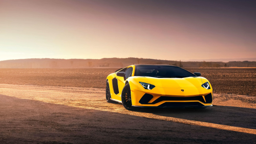

In [5]:
from fastdownload import download_url
dest = 'car.jpg'
download_url(urls[0], dest, show_progress=True)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256, 256)

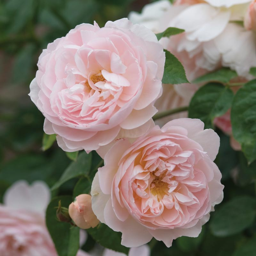

In [7]:
# get an image for not car test
download_url(search_images('term=rose gentle hermione', max_images=1)[0], 'rose.jpg', show_progress=False)
Image.open('rose.jpg').to_thumb(256,256)

### download images of cars and forest

In [8]:
searches = 'car', 'rose gentle hermione'
path = Path('car_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(F'{o} photo'))
    sleep(3)
    download_images(dest, urls=search_images(F'{o} sun photo'))
    sleep(3)
    download_images(dest, urls=search_images(F'{o} shade photo'))
    sleep(3)

    resize_image(path/o, max_size=400, dest=path/o)



In [10]:
#remove failed images
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

18

### train model

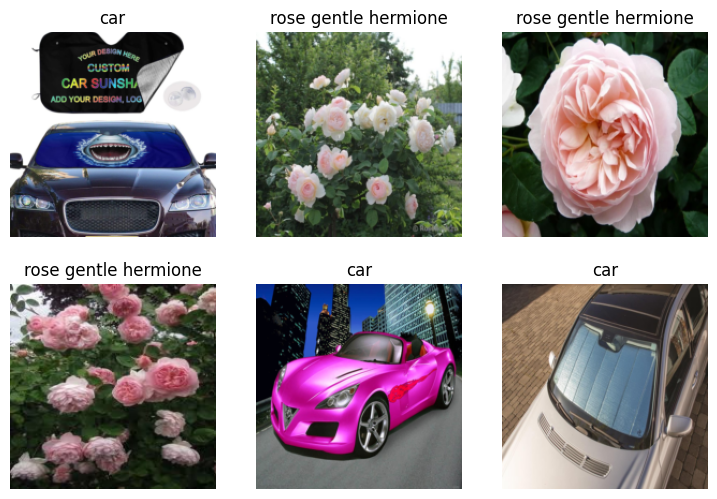

In [11]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

In [13]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/home/paperspace/pdlc-fastai/.devcontainer/venv/pdlc/lib/python3.11/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/home/paperspace/pdlc-fastai/.devcontainer/venv/pdlc/lib/python3.11/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/paperspace/pdlc-fastai/.devcontainer/venv/pdlc/lib/python3.11/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/paperspace/pdlc-fastai/.devcontainer/venv/pdlc/lib/python3.11/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


### use model for predictions


In [15]:
is_car,_,probs=learn.predict(PILImage.create('rose.jpg'))
print(f'this is a {is_car}.')
print(f"probability it's a car: {probs[0]:.4f}")

this is a rose gentle hermione.
probability it's a car: 0.0000


In [21]:
new_url=search_images('car with flowers', max_images=10)
print(new_url, sep='\n')

['https://thumbs.dreamstime.com/z/pink-classic-convertible-car-flowers-hood-old-germany-car-pink-classic-convertible-car-flowers-hood-160915042.jpg', 'https://flowerpowerdaily.com/wp-content/uploads/2020/07/IMG_9856.jpg', 'https://jooinn.com/images/wedding-car-decorated-with-flowers.jpg', 'https://i.pinimg.com/originals/4c/e5/d8/4ce5d81db8ba74cf17dc0702bc9aca3b.jpg', 'https://www.bloomsonly.com/wpblog/wp-content/uploads/2018/07/x1-700x525.jpg', 'https://i.pinimg.com/originals/72/4d/af/724daf05d54af3851473f2c4677b0438.jpg', 'https://s-media-cache-ak0.pinimg.com/736x/f1/fe/71/f1fe71e7530f2a9c6005e7ef091b62f6.jpg', 'https://images.squarespace-cdn.com/content/v1/582c5b3946c3c4ab87870922/1572346614964-D9D8I7LKZK1WT5XPEW35/flower+car+shoot_0140.jpg', 'https://thumbs.dreamstime.com/b/vintage-colorful-auto-loaded-flowers-transformed-decoration-bright-pink-retro-car-decorated-lot-multicolored-243313921.jpg', 'https://www.weddingstats.org/wp-content/uploads/2020/07/flower-decorating-for-car-1024

In [22]:
path = Path('car_or_not')
dest = (path/'hard')
dest.mkdir(exist_ok=True, parents=True)
download_images(dest, urls=search_images('car with flowers'))
resize_images(dest, max_size=400, dest=dest)

/home/paperspace/pdlc-fastai/.devcontainer/venv/pdlc/lib/python3.11/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/paperspace/pdlc-fastai/.devcontainer/venv/pdlc/lib/python3.11/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/paperspace/pdlc-fastai/.devcontainer/venv/pdlc/lib/python3.11/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [23]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

7

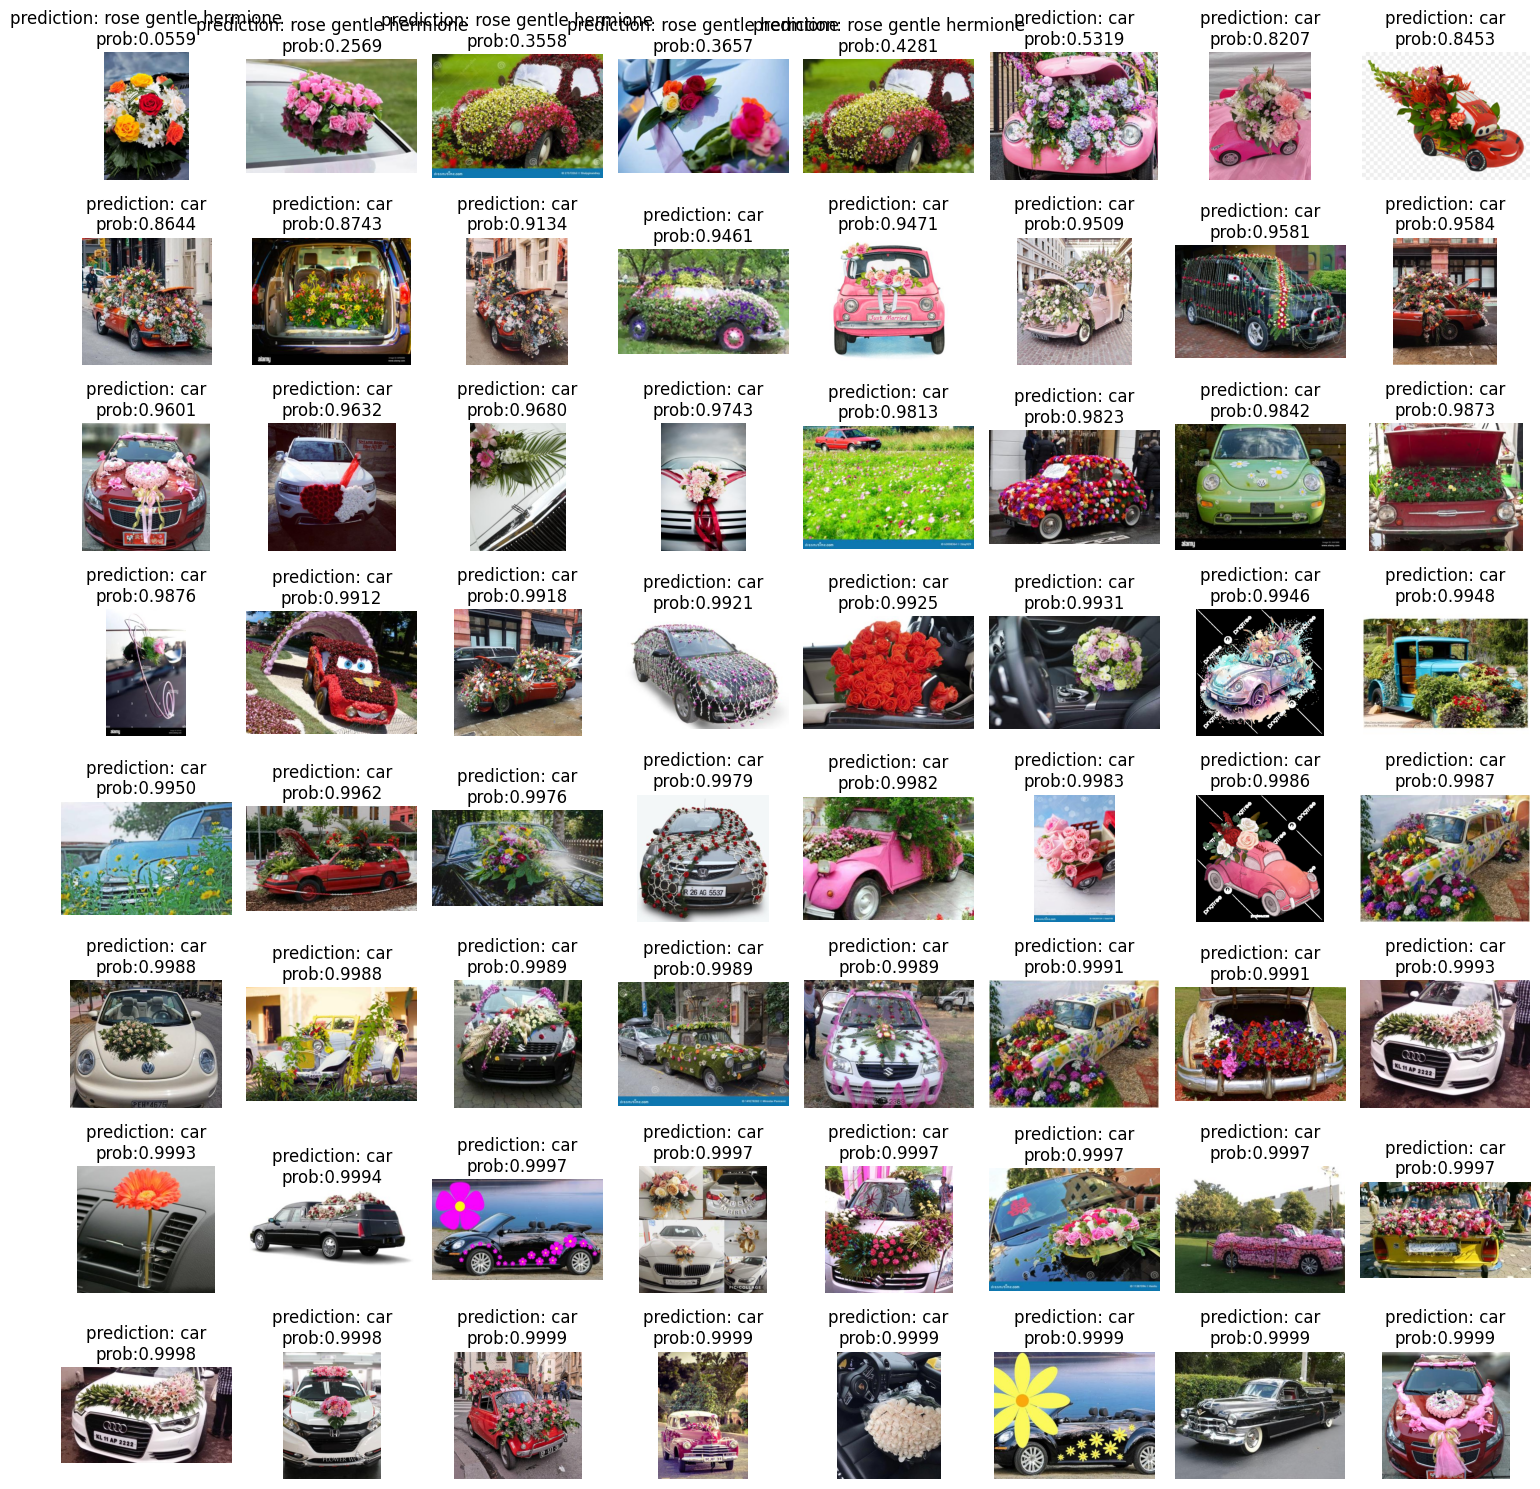

In [40]:
from fastai.vision.all import *
import matplotlib.pyplot as plt

path = Path('car_or_not')
dest = (path/'hard')

num_rows = 8
num_cols = 8
num_images = num_rows * num_cols

fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 15))
axs = axs.flatten()

extensions = ['*.png', '*.jpg', '*.jpeg']
image_files = []

image_probs = []

for ext in extensions:
    image_files.extend(dest.glob(ext))

for img_path in image_files:
    img = PILImage.create(str(img_path))
    _, _, probs = learn.predict(img)
    image_probs.append((img_path, probs[0]))

image_probs.sort(key=lambda x: x[1], reverse=False)

for i, (img_path, prob) in enumerate(image_probs):
    if i >= num_images:
        break

    img = PILImage.create(str(img_path))
    is_car, _, _ = learn.predict(img)

    axs[i].imshow(img)
    axs[i].set_title(f'prediction: {is_car}\nprob:{prob:.4f}')
    axs[i].axis('off')


plt.tight_layout()
plt.show()


